<a href="https://colab.research.google.com/github/K-107/Anomaly-Detection/blob/main/%EC%83%81%EC%9D%BC%EC%9D%B4%EB%84%A4_2%EC%B0%A8%ED%94%84%EC%A0%9D_AE%EB%A1%9C_%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 깃주소 https://github.com/lignas12015/project2
# 구글 드라이브에서 데이터 가져오기

In [2]:
% cd /content/drive/MyDrive/이상치탐지

/content/drive/MyDrive/이상치탐지


In [2]:
! unzip '*.zip'

Archive:  drive-download-20211002T114535Z-001.zip
  inflating: 20201201_항목설명.xlsx  
  inflating: 적발내역_Таблица выявленных нарушений для майнинга_1118.xlsx  
  inflating: imp_2017_1-4.xlsx       
  inflating: imp_2018_1-4.xlsx       
  inflating: imp_2020_5-8.xlsx       
  inflating: imp_2017_9-12.xlsx      
  inflating: imp_2020_9-11.xlsx      
  inflating: imp_2017_5-8.xlsx       
  inflating: imp_2019_1-4.xlsx       
  inflating: imp_2020_1-4.xlsx       
  inflating: imp_2018_5-8.xlsx       
  inflating: imp_2019_9-12.xlsx      
  inflating: imp_2019_5-8.xlsx       
  inflating: imp_2018_9-12.xlsx      


# 상일이네 기본 데이터 생성 코드

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## feature 데이터 불러오기

In [8]:
import os
files = os.listdir() # 해당 디렉토리에 접근

# 해당 디렉토리에 있는 파일 중 imp라는 문구가 포함된 파일명을 리스트에 포함
files = [file for file in files if 'imp' in file]
files.sort()
files

['imp_2017_1-4.xlsx',
 'imp_2017_5-8.xlsx',
 'imp_2017_9-12.xlsx',
 'imp_2018_1-4.xlsx',
 'imp_2018_5-8.xlsx',
 'imp_2018_9-12.xlsx',
 'imp_2019_1-4.xlsx',
 'imp_2019_5-8.xlsx',
 'imp_2019_9-12.xlsx',
 'imp_2020_1-4.xlsx',
 'imp_2020_5-8.xlsx',
 'imp_2020_9-11.xlsx']

## 개별 imp 데이터 내의 중복행 확인

In [6]:
for file in files:
  tmp_df=pd.read_excel('./{}'.format(file), engine='openpyxl')
  print('#',str(file)[:-4])
  print('전체 sample 수 :',len(tmp_df))
  print('중복 sample 수 :',tmp_df.duplicated().sum())
  print()

# imp_2017_1-4.
전체 sample 수 : 150195
중복 sample 수 : 40753

# imp_2018_1-4.
전체 sample 수 : 181293
중복 sample 수 : 37724



KeyboardInterrupt: ignored

## imp 데이터 병합


In [9]:
df = pd.read_excel('./imp_2017_1-4.xlsx', engine='openpyxl')
# 2017_1-4 파일의 중복행 제거 (40753개)
df.drop_duplicates(inplace=True)
# tdqm : 진행 사항을 bar 형태로 표시
for file in tqdm(files[1:]): # 앞에서 2017_1-4 파일은 불러왔으므로 2017_5-8 파일부터 반복문 실행
    # format을 이용해 파일을 하나씩 불러옴
    temp_df = pd.read_excel('./{}'.format(file), engine='openpyxl')
    temp_df.drop_duplicates(inplace=True) # 중복행 제거
    df = df.append(temp_df) # 기존에 생성된 데이터프레임에 추가

100%|██████████| 11/11 [47:03<00:00, 256.64s/it]


In [10]:
# CUS_REF_NO_7 칼럼에 우측 공백이 존재하므로 삭제
df['CUS_REF_NO_7']=df['CUS_REF_NO_7'].apply(lambda x : x.rstrip())
# 중복행이 모두 제거된 상태임을 확인
df.duplicated().sum()

0

In [12]:
# DataFrame 형태 확인
df.shape

(2148126, 73)

## label 데이터 불러오기
적발내역 데이터 불러오기
- 적발내역엔 있지만 imp 데이터엔 없는 sample들 존재 확인 할 것

In [30]:
# 인덱스로 사용할 위치 지정(0)
illegal = pd.read_excel('적발내역.xlsx', sheet_name=1, engine="openpyxl")
'''
엑셀 가져올 때
TypeError: expected <class 'str'>가 발생하면...
http://pertinency.blogspot.com/2020/04/ 여기서 알려주는대로 해라!
'''

# 불필요한 열 제거
illegal.drop(['Unnamed: 0','Unnamed: 1','Unnamed: 11'], axis=1, inplace=True)
# 칼럼 이름 변환
illegal.rename(columns={'해당년도':'YEAR','업체':'IMP_COMPANY','적발건수':'NUMB_OF_DETECTED','세관코드':'CUSTOMS_CODE','신고서No.':'CUST_NUMBER', 
                        'Unnamed: 7':'HS_CODE','품목':'GOODS','검사결과코드':'INSPECTION_RESULT_CODE','위반사항':'VIOLATIONS'},inplace=True)
# 0 번째 행은 키릴문자로 된 칼럼 설명이므로 삭제
illegal.drop(0,inplace=True)
# CUST_NUMBER 칼럼에 우측 공백이 존재하므로 삭제
# illegal['CUST_NUMBER']=illegal['CUST_NUMBER'].apply(lambda x : x.rstrip())
# 적발내역을 pickle 파일로 저장

illegal = illegal[:403] # 403행 이후에는 다 nan이다.
illegal.to_pickle('./01_detection_detail.pkl')
illegal

,YEAR,IMP_COMPANY,NUMB_OF_DETECTED,CUSTOMS_CODE,CUST_NUMBER,HS_CODE,GOODS,INSPECTION_RESULT_CODE,VIOLATIONS,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
1,2019.0,"ЧДММ ""Корафзо""",1,762118.0,762118/200117/0000002,6907100000,Кафел,C202,Недостоверная классификация товара (код товара),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019.0,"ЧДММ ""Рахмат И К""",1,762118.0,762118/040617/0000012,6907100000,"Кафел, камни.",C202,Недостоверная классификация товара (код товара),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019.0,"ЧДММ ""Сохтмони водии вахш-2015""",1,762118.0,762118/260417/0100105,3903909000,Полипропилен-гранула,C202,Недостоверная классификация товара (код товара),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019.0,"ЧДММ ""Сайри Диёр""",1,762118.0,762118/280518/0000230,3903909000,Полипропилен-гранула,C104,Незаконное применение таможеных преференций,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019.0,"ЧДММ ""Сайри Диёр""",2,762118.0,762118/300518/0000232,3903909000,Полипропилен-гранула,C104,Незаконное применение таможеных преференций,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,2020.0,ЧДММ Вахдат 2020,1,762230.0,762230/270320/0000483,4417000000,ручка от лопаты,C204,Занижения таможенной стоимости,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,2020.0,ЧДММ Кафолат Содирот Воридот,1,762230.0,762230/130520/0000635,8708299009,автозапчасть,C204,Занижения таможенной стоимости,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,2020.0,ЧДММ Сафари,1,762249.0,762249/290319/0000479,3208209009,Краска,C204,Занижения таможенной стоимости,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,2020.0,ЧДММ Сафари,2,762249.0,762249/120620/0001093,3208209009,Краска,C204,Занижения таможенной стоимости,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# 적발내역에는 존재하지만 본 세관 데이터에는 존재하지 않는 신고서 번호가 13개 존재
cust_numb_list=[]

for number in illegal['CUST_NUMBER']:
  if number not in list(df['CUS_REF_NO_7']):
    print(number)
    cust_numb_list.append(number)

print(len(cust_numb_list))

762118/200117/0000002
762118/040617/0000012
761118/290618/0000305
761118/300818/0000444
762224/291118/П004751
762417/110317/0000014
762417/010417/0000022
762417/290417/0000029
762417/101118/0000127
762419/220717/0000094
762417/090917/0000090
762419/200517/0000065
762420/010917/0000012
13


## feature 데이터와 label 데이터 병합
label 데이터에서 인덱스별로 CUST_NUMBER와 HS_CODE 튜플 추출

In [32]:
ill_idx = [] # 적발된 cust_number와 hs_code를 담을 list

# iterrows를 통해 (인덱스, 해당 두 컬럼의 데이터)를 각각 (n, i) 에 반환
for n, i in illegal[['CUST_NUMBER', 'HS_CODE']].iterrows():
    try:
        tup = (i.CUST_NUMBER, int(i.HS_CODE)) 
        ill_idx.append(tup)
    except:
        pass
ill_idx[:5]

[('762118/200117/0000002', 6907100000),
 ('762118/040617/0000012', 6907100000),
 ('762118/260417/0100105', 3903909000),
 ('762118/280518/0000230', 3903909000),
 ('762118/300518/0000232', 3903909000)]

## label 칼럼 생성

In [33]:
df['LABEL'] = 0 #종속변수 column
df.reset_index(drop=True, inplace=True)
df.iloc[:5, -3:]

,GEND_ISSUE_DATE_54,ACCEPTANCE_DATE,LABEL
0,20150624.0,"14.02.17 11:55:18,551000000",0
1,20150624.0,"14.02.17 11:55:18,551000000",0
2,20150624.0,"14.02.17 11:55:18,551000000",0
3,20150624.0,"14.02.17 15:53:44,921000000",0
4,20150624.0,"14.02.17 15:53:44,921000000",0


## 적발에 해당하는 label은 0에서 1로 변경 및 기본 데이터 완성

In [35]:
# 적발 리스트의 인덱스 길이만큼 반복시행
for i in range(len(ill_idx)):
  
    # 적발 리스트의 CUST_NUMBER가 feature 데이터의 CUS_REF_NO_7에 존재하는 경우 그 index를 idx에 저장
    idx = df[df.CUS_REF_NO_7 == ill_idx[i][0]].index 
    if len(idx) != 0: # 바로 위 코드의 결과 적발 데이터가 존재할 경우
        for i in range(len(idx)): # idx에 포함된 모든 index만큼 반복문 실행
            df['LABEL'].iloc[idx[i]] = 1 # idx에 포함된 index에 대하여 y를 1로 변경
            
# 클래스 0과 클래스 1의 개수 확인
print(df.LABEL.value_counts())

# 중복 제거된 feature에 위법물 label을 단 DataFrame을 pickle로 저장
df.to_pickle('./00_feature_with_label.pkl')
df

0    2134165
1      13961
Name: LABEL, dtype: int64


,IMP_TYPE_OF_DECLARATION_1,IMP_TYPE_OF_DECLARATION_2,TRD_TIN_2,TRD_NAME_2,TRD_COUNTRY_2,TRD_ADDR_2,CUS_SHIPMENT_SPEC_4,CUS_TOTAL_NUMBER_OF_ITEMS_5,CUS_TOTAL_NUMBER_OF_PACKAGES_6,CUS_REF_NO_7,CON_TIN_8,CON_NAME_8,CON_COUNTRY_8,CON_ADDR_8,PER_TIN_9,PER_NAME_9,PER_COUNTRY_9,PER_ADDR_9,IMP_TRADING_COUNTRY_11,VAL_FINANCIAL_VALUE_12,VAL_CURRENCY_12,DNT_TIN_14,DNT_NAME_14,DNT_COUNTRY_14,DNT_ADDR_14,IMP_CNT_OF_DISPATCH_EXP_CD_15,IMP_COUNTRY_OF_ORIGIN_16,IMP_CONTAINER_FLAG_19,DEL_DELIVERY_TERM_CODE_20,DEL_PLACE_OF_DELIVERY_20,TOT_CURRENCY_22,TOT_FINANCIAL_VALUE_22,IMP_EXCHANGE_RATE_23,IMP_INLAND_TRANSPORT_MODE_25,IMP_TRANSPORT_MODE_AT_BODR_26,LOD_LOCATION_NAME_27,LOC_LOCATION_NAME_30,OFF_CODE_30,GDS_GOODS_DESCRIPTION_31,GDS_ITEM_NUMBER_32,COM_COMBINED_NOMENCLATURE_33,IDG_COUNTRY_OF_ORIGIN_34,GDS_GROSS_MASS_35,PRF_PREFERENCE_CODE_1,PRF_PREFERENCE_CODE_2,PRF_PREFERENCE_CODE_3,PRF_PREFERENCE_CODE_4,IDG_PROCEDURE_REQUESTED_37,IDG_PREVIOUS_PROCEDURE_37,IDG_ADD_NATIONAL_PROC_37,IDG_NET_MASS_38,IDG_QUOTA,ZQNTY,ZAUXUOM,FIN_FINANCIAL_VALUE_42,COR_FINANCIAL_VALUE,COR_CURRENCY,COV_CUST_VALUE_METHOD,STC_FINANCIAL_VALUE_46,IDG_STAT_VALUE_VAL_METH_46,CAL_TYPE_OF_TAX_47,CAL_TAX_BASE_47,CAL_RATE_OF_TAX_47,CAL_ADDITIONAL_RATE_OF_TAX_47,PAM_FINANCIAL_VALUE_47,CAL_METHOD_OF_PAYMENT_47,IMP_DATE_OF_DECLARATION_54,REP_TIN_54,PERSON_NAME_54,PERSON_POSITION_54,GEND_REFERENCE_54,GEND_ISSUE_DATE_54,ACCEPTANCE_DATE,LABEL
0,ИМ,NaN,NaN,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,NaN,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,RU,0.0,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20.0,20.0,NaN,Ж/Д ДЖ.РАСУЛОВ,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,NaN,185.52,113.0,2046973.0,345737.87,TJS,1.0,43705.0,1.0,10.0,345737.87,70.00,SP,553.76,БН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СПЕЦИАЛИСТ ПО Т/О,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
1,ИМ,NaN,NaN,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,NaN,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,RU,0.0,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20.0,20.0,NaN,Ж/Д ДЖ.РАСУЛОВ,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,NaN,185.52,113.0,2046973.0,345737.87,TJS,1.0,43705.0,1.0,20.0,345737.87,5.00,AD,17286.89,УН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СПЕЦИАЛИСТ ПО Т/О,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
2,ИМ,NaN,NaN,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,NaN,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,RU,0.0,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20.0,20.0,NaN,Ж/Д ДЖ.РАСУЛОВ,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,NaN,185.52,113.0,2046973.0,345737.87,TJS,1.0,43705.0,1.0,30.0,345737.87,18.00,AD,62232.82,БН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СПЕЦИАЛИСТ ПО Т/О,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
3,ИМ,NaN,NaN,""" М/С АКИДЖ ДУТЕ МИЛЛС ЛТД"",Ч/З БАНДАР АБАС П/...",BD,АББАС,NaN,1,1213.0,762241/140217/0100665,560002910,"ООО ""РОСТОИ СУГД""",TJ,ГУЛИСТОН И.СОМОНИ 1,560002910,"ООО ""РОСТОИ СУГД""",TJ,ГУЛИСТОН И.СОМОНИ 1,AE,346493.04,TJS,560002910,"ООО ""РОСТОИ СУГД""",TJ,ГУЛИСТОН И.СОМОНИ 1,BD,BD,0.0,CIP,ГУЛИСТОН,USD,43800.0,7.9108,20.0,20.0,NaN,Ж/Д ХУДЖАНД,762241,"ВОЛОКНО СИНТЕТИЧЕСКОЕ,ИЗ ДЖУТА",1,5307200000,BD,46640.0,О,А,О,О,40,0,0,45000.0,NaN,NaN,NaN,43800.0,346493.04,TJS,1.0,43800.0,1.0,10.0,346493.04,70.00,SP,553.76,БН,20170214,510000091,САЙФИЕВА МАВЗУНА ШАРИФДЖАНОВНА,СПЕЦИАЛИСТ,СГ/01/007

## 데이터셋 불러오기

In [5]:
df_origin = pd.read_pickle('./00_feature_with_label.pkl')

## 결측치 대체 / 삭제

In [6]:
# 전체 null값 개수와 그 중 LABEL 1인 것들의 개수를 출력하는 함수 생성
def get_result(column_name) :
    mask1 = df_origin['{}'.format(column_name)].isnull()
    tmp_df = df_origin[mask1]
    mask2 = tmp_df.LABEL == 1
    
    print('##### {} #####'.format(column_name))
    print('Number of null : {}'.format(len(tmp_df)))
    print('Label 1 null : {}'.format(len(tmp_df[mask2])))
    return tmp_df

In [7]:
# 연속형 변수들을 함수에 대입하여 전체 null값 개수와 그 중 LABEL이 1인 것들의 개수를 확인

columns =  ['CUS_TOTAL_NUMBER_OF_PACKAGES_6', 'VAL_FINANCIAL_VALUE_12',
            'TOT_FINANCIAL_VALUE_22', 'IMP_EXCHANGE_RATE_23',
            'IMP_INLAND_TRANSPORT_MODE_25', 'IMP_TRANSPORT_MODE_AT_BODR_26',
            'GDS_GROSS_MASS_35', 'IDG_NET_MASS_38', 'FIN_FINANCIAL_VALUE_42',
            'STC_FINANCIAL_VALUE_46']

for column in columns : 
    get_result(column)

# 결과를 살펴보면 label = 1인 null값은 한개도 없음
# 따라서 null값의 수가 많은 column들(500개 이상)만 대체 고려,

##### CUS_TOTAL_NUMBER_OF_PACKAGES_6 #####
Number of null : 151
Label 1 null : 0
##### VAL_FINANCIAL_VALUE_12 #####
Number of null : 56
Label 1 null : 0
##### TOT_FINANCIAL_VALUE_22 #####
Number of null : 87
Label 1 null : 0
##### IMP_EXCHANGE_RATE_23 #####
Number of null : 11704
Label 1 null : 0
##### IMP_INLAND_TRANSPORT_MODE_25 #####
Number of null : 847
Label 1 null : 0
##### IMP_TRANSPORT_MODE_AT_BODR_26 #####
Number of null : 1020
Label 1 null : 0
##### GDS_GROSS_MASS_35 #####
Number of null : 567
Label 1 null : 0
##### IDG_NET_MASS_38 #####
Number of null : 590
Label 1 null : 0
##### FIN_FINANCIAL_VALUE_42 #####
Number of null : 162
Label 1 null : 0
##### STC_FINANCIAL_VALUE_46 #####
Number of null : 17
Label 1 null : 0


IMP_EXCHANGE_RATE_23
- TOT_CURRENCY_22 = TJS 인 sample은 null값을 1로 대체 (자국 화폐이므로)

In [8]:
mask = (df_origin.TOT_CURRENCY_22 == 'TJS') & (df_origin.IMP_EXCHANGE_RATE_23.isnull())
idx = df_origin[mask].index
for i in idx :
    df_origin.iloc[i, 32] = 1
df_origin[mask]['IMP_EXCHANGE_RATE_23'].unique()

array([1.])

IMP_INLAND_TRANSPORT_MODE_25, IMP_TRANSPORT_MODE_AT_BODR_26

In [9]:
# 출력값에서 볼 수 있듯이 이 둘은 float값을 지니고 있지만 사실상 명목 변수
print(df_origin.IMP_INLAND_TRANSPORT_MODE_25.unique())
print(df_origin.IMP_TRANSPORT_MODE_AT_BODR_26.unique())

[20. 30. 40. 90. nan 50. 70. 80. 10. 18. 23.]
[20. 30. 40. 90. nan 50. 70. 23. 80. 10.]


In [10]:
# null값 0으로 대체 후 int로 변환
for column in ['IMP_INLAND_TRANSPORT_MODE_25', 'IMP_TRANSPORT_MODE_AT_BODR_26'] :
    df_origin['{}'.format(column)].fillna(0, inplace=True)
    df_origin['{}'.format(column)] = df_origin['{}'.format(column)].astype(int)
    print(df_origin['{}'.format(column)].unique())

[20 30 40 90  0 50 70 80 10 18 23]
[20 30 40 90  0 50 70 23 80 10]


GDS_GROSS_MASS_35, IDG_NET_MASS_38

In [11]:
# 해당하는 칼럼들만 추출하여 DataFrame 생성
edf = df_origin[['COM_COMBINED_NOMENCLATURE_33','GDS_GROSS_MASS_35', 'IDG_NET_MASS_38']]
edf

,COM_COMBINED_NOMENCLATURE_33,GDS_GROSS_MASS_35,IDG_NET_MASS_38
0,4410110009,128000.0,121145.0
1,4410110009,128000.0,121145.0
2,4410110009,128000.0,121145.0
3,5307200000,46640.0,45000.0
4,5307200000,46640.0,45000.0
...,...,...,...
2148121,8703239013,1610.0,1610.0
2148122,8703239013,1610.0,1610.0
2148123,4011990000,204.0,204.0
2148124,4011990000,204.0,204.0


In [12]:
# null값 대체를 위한 사용자 함수 생성

def translation(column_name) :

  # 해당 칼럼의 null값이 있는 샘플만 인덱싱하여 해당 샘플의 인덱스와 HS-CODE를 리스트로 저장 
  mask = edf[column_name].isnull()
  idx_list = edf[mask].index.tolist()
  hs_list = edf[mask]['COM_COMBINED_NOMENCLATURE_33'].unique().tolist()

  # HS-CODE별로 GDS_GROSS_MASS_35, IDG_NET_MASS_38의 평균 산출 후 dictionary 생성 
  mean_list = []
  for code in hs_list :
    mask = edf['COM_COMBINED_NOMENCLATURE_33'] == code
    mean = edf[mask][column_name].mean()
    mean_list.append(mean)
  mean_dict = dict(zip(hs_list, mean_list))

  # dictionary를 사용하여 null값 대체 
  for i in idx_list :
    val = edf.iloc[i, 0]
    if column_name == 'GDS_GROSS_MASS_35' :
      edf.iloc[i, 1] = mean_dict[val]
    elif column_name == 'IDG_NET_MASS_38' :
      edf.iloc[i, 2] = mean_dict[val]

for column in ['GDS_GROSS_MASS_35', 'IDG_NET_MASS_38'] :
  translation(column)

for column in ['GDS_GROSS_MASS_35', 'IDG_NET_MASS_38'] :
  df_origin[column] = edf[column]

In [13]:
# null값이 100개 대로 줄어든 것을 확인 가능
columns =  ['CUS_TOTAL_NUMBER_OF_PACKAGES_6', 'VAL_FINANCIAL_VALUE_12',
            'TOT_FINANCIAL_VALUE_22', 'IMP_EXCHANGE_RATE_23',
            'IMP_INLAND_TRANSPORT_MODE_25', 'IMP_TRANSPORT_MODE_AT_BODR_26',
            'GDS_GROSS_MASS_35', 'IDG_NET_MASS_38', 'FIN_FINANCIAL_VALUE_42',
            'STC_FINANCIAL_VALUE_46']

for column in columns : 
    get_result(column)

##### CUS_TOTAL_NUMBER_OF_PACKAGES_6 #####
Number of null : 151
Label 1 null : 0
##### VAL_FINANCIAL_VALUE_12 #####
Number of null : 56
Label 1 null : 0
##### TOT_FINANCIAL_VALUE_22 #####
Number of null : 87
Label 1 null : 0
##### IMP_EXCHANGE_RATE_23 #####
Number of null : 58
Label 1 null : 0
##### IMP_INLAND_TRANSPORT_MODE_25 #####
Number of null : 0
Label 1 null : 0
##### IMP_TRANSPORT_MODE_AT_BODR_26 #####
Number of null : 0
Label 1 null : 0
##### GDS_GROSS_MASS_35 #####
Number of null : 12
Label 1 null : 0
##### IDG_NET_MASS_38 #####
Number of null : 12
Label 1 null : 0
##### FIN_FINANCIAL_VALUE_42 #####
Number of null : 162
Label 1 null : 0
##### STC_FINANCIAL_VALUE_46 #####
Number of null : 17
Label 1 null : 0


In [14]:
########## Class ##########


### 전처리에 사용할 class

class Preprocess :
    
    def __init__(self, df) :
        self.df = df
    
    
    ##### Class Variables #####
    
    
    # 사용이 불가능하다고 판단, 데이터프레임에서 아예 드랍시킬 컬럼들(추후 변동 가능)
    
    drop_col_list = ['IMP_TYPE_OF_DECLARATION_1', 'IMP_TYPE_OF_DECLARATION_2',
                     'TRD_TIN_2', 'CUS_SHIPMENT_SPEC_4',
                     'PER_TIN_9', 'PER_NAME_9', 'PER_COUNTRY_9', 'PER_ADDR_9',
                     'DNT_TIN_14', 'DNT_NAME_14', 'DNT_COUNTRY_14', 'DNT_ADDR_14',
                     'IMP_CONTAINER_FLAG_19', 'LOD_LOCATION_NAME_27', 'IDG_QUOTA',
                     'ZQNTY', 'ZAUXUOM', 'PERSON_POSITION_54', 'LOC_LOCATION_NAME_30',
                     'COV_CUST_VALUE_METHOD', 'IDG_STAT_VALUE_VAL_METH_46']
    
    
    # 사용은 가능하지만 중간에 null값이 있는 명목형 컬럼들. fillna로 처리(추후 변동 가능)
    
    fillna_col_list = ['TRD_COUNTRY_2', 'CUS_REF_NO_7', 'CON_COUNTRY_8',
                       'IMP_TRADING_COUNTRY_11', 'VAL_CURRENCY_12',
                       'IMP_CNT_OF_DISPATCH_EXP_CD_15', 'DEL_DELIVERY_TERM_CODE_20',
                       'TOT_CURRENCY_22',
                       'DEL_PLACE_OF_DELIVERY_20']
    
    
    # 사용은 가능하지만 중간에 null값이 있는 연속형 컬럼들. fillna로 처리(추후 변동 가능)

    num_col_list = ['CUS_TOTAL_NUMBER_OF_PACKAGES_6', 'VAL_FINANCIAL_VALUE_12',
                    'TOT_FINANCIAL_VALUE_22', 'IMP_EXCHANGE_RATE_23',
                    'GDS_GROSS_MASS_35', 'IDG_NET_MASS_38', 'FIN_FINANCIAL_VALUE_42',
                    'STC_FINANCIAL_VALUE_46']
               

    # Label 에 영향을 미치지 않아 단순히 null이 존재하는 인덱스만 드랍(추후 변동 가능)

    index_drop_list = ['PRF_PREFERENCE_CODE_1', 'COR_FINANCIAL_VALUE', 'GEND_REFERENCE_54',
                       'CAL_TYPE_OF_TAX_47', 'CAL_ADDITIONAL_RATE_OF_TAX_47']
    
    
    ##### Class Methods #####
    
    
    # null값 제거 사용자 함수
    def null_solution(self):

        df = self.df.copy()
        for column_name in df.columns :
            
            # 사용하기 힘든 칼럼들 drop
            if column_name in self.drop_col_list :
                df.drop(column_name, axis=1, inplace=True)
            
            # fillna_col_list에 포함되있다면 null값을 'null'로 대체
            elif column_name in self.fillna_col_list :
                df[column_name].fillna('null', inplace=True)
            
            # num_col_list에 포함되 있다면 컬럼의 평균값으로 null값을 대체
            elif column_name in self.num_col_list :
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            
            # index_drop_list에 속한 칼럼들은 해당 index를 삭제
            elif column_name in self.index_drop_list :
                drop_idx = df[df[column_name].isnull()].index
                df.drop(drop_idx, axis=0, inplace=True)
            
        return df
       

 ### 인코딩에 사용할 class
class Encoder :
    
    def __init__(self, df) :
        self.df = df

    # Label Encoder
    def label(self, classes=None) :
        
        # 초기화 때 입력한 DataFrame의 사본을 사용
        df = self.df.copy()
        
        # LabelEncoder 객체 생성
        from sklearn.preprocessing import LabelEncoder
        import numpy as np
        import pandas as pd
        import pickle

        le = LabelEncoder()
                
        # for문을 사용, 각 칼럼별로 인코딩 적용
        for column in df.columns:
            # 칼럼의 데이터 타입이 str인 것만 인코딩 실시
            if type(df[column][0]) == str :
                # Label Encoding 실시
                column_encoded = le.fit_transform(df[column])
                df[column] = column_encoded
                # 인코딩한 칼럼 이름을 변수명으로 하는 dict 변수 생성
                # 칼럼_이름 = {원래 데이터 : 인코딩 된 번호}
                encoding_val = np.sort(df[column].unique())
                decoding_val = le.classes_
                val_dict = dict(zip(decoding_val, encoding_val))
                # dict를 pkl로 저장
                with open('./Label_Encoding_dict/{}.pickle'.format(column), 'wb') as f :
                  pickle.dump(val_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

            else : pass
               
        return df
    
    # One-hot Encoder
    def one_hot(self) :

      import numpy as np
      import pandas as pd

      # self.df의 복사본 생성
      df = self.df.copy()
      # 인코딩 대상 칼럼 넣는 DataFrame
      # 이렇게 하는 이유 : 안그러면 칼럼 이름에 값만 뜸
      # 이렇게 해주면 칼럼 이름으로 원래 칼럼 이름 + 값이 뜸
      oh_columns = pd.DataFrame()

      # for loop로 대상 칼럼 oh_columns에 넣고
      # df에서는 삭제
      for column in df.columns :
        if str(df[column].dtype) == 'object' :
          oh_columns[column] = df[column]
          df.drop(column, axis=1, inplace=True)
        else : pass
      # get_dummies 함수 사용하여 one_hot 진행
      oh_df = pd.get_dummies(oh_columns)
      for value in oh_df.columns :
        df[value] = oh_df[value]
      
      return df

    
########## Methods ##########

In [15]:
# 나머지 null값은 이전과 같이 평균 대체 진행

pre_df_origin = Preprocess(df_origin)
basic_feature_df = pre_df_origin.null_solution()
basic_feature_df.isnull().sum()

# 결측값이 모두 제거된 것을 확인 가능

TRD_NAME_2                        0
TRD_COUNTRY_2                     0
TRD_ADDR_2                        0
CUS_TOTAL_NUMBER_OF_ITEMS_5       0
CUS_TOTAL_NUMBER_OF_PACKAGES_6    0
CUS_REF_NO_7                      0
CON_TIN_8                         0
CON_NAME_8                        0
CON_COUNTRY_8                     0
CON_ADDR_8                        0
IMP_TRADING_COUNTRY_11            0
VAL_FINANCIAL_VALUE_12            0
VAL_CURRENCY_12                   0
IMP_CNT_OF_DISPATCH_EXP_CD_15     0
IMP_COUNTRY_OF_ORIGIN_16          0
DEL_DELIVERY_TERM_CODE_20         0
DEL_PLACE_OF_DELIVERY_20          0
TOT_CURRENCY_22                   0
TOT_FINANCIAL_VALUE_22            0
IMP_EXCHANGE_RATE_23              0
IMP_INLAND_TRANSPORT_MODE_25      0
IMP_TRANSPORT_MODE_AT_BODR_26     0
OFF_CODE_30                       0
GDS_GOODS_DESCRIPTION_31          0
GDS_ITEM_NUMBER_32                0
COM_COMBINED_NOMENCLATURE_33      0
IDG_COUNTRY_OF_ORIGIN_34          0
GDS_GROSS_MASS_35           

In [16]:
# 결측값 제거된 DataFrame을 pickle 파일로 저장
basic_feature_df.to_pickle('./20_basic_feature_df.pkl')

## 피쳐 엔지니어링

In [17]:
odf = pd.read_pickle('./20_basic_feature_df.pkl')
df = odf.copy()
odf

,TRD_NAME_2,TRD_COUNTRY_2,TRD_ADDR_2,CUS_TOTAL_NUMBER_OF_ITEMS_5,CUS_TOTAL_NUMBER_OF_PACKAGES_6,CUS_REF_NO_7,CON_TIN_8,CON_NAME_8,CON_COUNTRY_8,CON_ADDR_8,IMP_TRADING_COUNTRY_11,VAL_FINANCIAL_VALUE_12,VAL_CURRENCY_12,IMP_CNT_OF_DISPATCH_EXP_CD_15,IMP_COUNTRY_OF_ORIGIN_16,DEL_DELIVERY_TERM_CODE_20,DEL_PLACE_OF_DELIVERY_20,TOT_CURRENCY_22,TOT_FINANCIAL_VALUE_22,IMP_EXCHANGE_RATE_23,IMP_INLAND_TRANSPORT_MODE_25,IMP_TRANSPORT_MODE_AT_BODR_26,OFF_CODE_30,GDS_GOODS_DESCRIPTION_31,GDS_ITEM_NUMBER_32,COM_COMBINED_NOMENCLATURE_33,IDG_COUNTRY_OF_ORIGIN_34,GDS_GROSS_MASS_35,PRF_PREFERENCE_CODE_1,PRF_PREFERENCE_CODE_2,PRF_PREFERENCE_CODE_3,PRF_PREFERENCE_CODE_4,IDG_PROCEDURE_REQUESTED_37,IDG_PREVIOUS_PROCEDURE_37,IDG_ADD_NATIONAL_PROC_37,IDG_NET_MASS_38,FIN_FINANCIAL_VALUE_42,COR_FINANCIAL_VALUE,COR_CURRENCY,STC_FINANCIAL_VALUE_46,CAL_TYPE_OF_TAX_47,CAL_TAX_BASE_47,CAL_RATE_OF_TAX_47,CAL_ADDITIONAL_RATE_OF_TAX_47,PAM_FINANCIAL_VALUE_47,CAL_METHOD_OF_PAYMENT_47,IMP_DATE_OF_DECLARATION_54,REP_TIN_54,PERSON_NAME_54,GEND_REFERENCE_54,GEND_ISSUE_DATE_54,ACCEPTANCE_DATE,LABEL
0,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,RU,RU,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20,20,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,2046973.0,345737.87,TJS,43705.0,10.0,345737.87,70.00,SP,553.76,БН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
1,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,RU,RU,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20,20,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,2046973.0,345737.87,TJS,43705.0,20.0,345737.87,5.00,AD,17286.89,УН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
2,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,RU,RU,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20,20,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,2046973.0,345737.87,TJS,43705.0,30.0,345737.87,18.00,AD,62232.82,БН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
3,""" М/С АКИДЖ ДУТЕ МИЛЛС ЛТД"",Ч/З БАНДАР АБАС П/...",BD,АББАС,1,1213.0,762241/140217/0100665,560002910,"ООО ""РОСТОИ СУГД""",TJ,ГУЛИСТОН И.СОМОНИ 1,AE,346493.04,TJS,BD,BD,CIP,ГУЛИСТОН,USD,43800.0,7.9108,20,20,762241,"ВОЛОКНО СИНТЕТИЧЕСКОЕ,ИЗ ДЖУТА",1,5307200000,BD,46640.0,О,А,О,О,40,0,0,45000.0,43800.0,346493.04,TJS,43800.0,10.0,346493.04,70.00,SP,553.76,БН,20170214,510000091,САЙФИЕВА МАВЗУНА ШАРИФДЖАНОВНА,СГ/01/0077,20150624.0,"14.02.17 15:53:44,921000000",0
4,""" М/С АКИДЖ ДУТЕ МИЛЛС ЛТД"",Ч/З БАНДАР АБАС П/...",BD,АББАС,1,1213.0,762241/140217/0100665,560002910,"ООО ""РОСТОИ СУГД""",TJ,ГУЛИСТОН И.СОМОНИ 1,AE,346493.04,TJS,BD,BD,CIP,ГУЛИСТОН,USD,43800.0,7.9108,20,20,762241,"ВОЛОКНО СИНТЕТИЧЕСКОЕ,ИЗ ДЖУТА",1,5307200000,BD,46640.0,О,А,О,О,40,0,0,45000.0,43800.0,346493.04,TJS,43800.0,20.0,346493.04,5.00,AD,8662.33,УН,20170214,510000091,САЙФИЕВА МАВЗУНА ШАРИФДЖАНОВНА,СГ/01/0077,20150624.0,"14.02.17 15:53:44,921000000",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148120,"ЗАО ""КЕМА""",LT,МАРИЯМПОЛЕ,8,8.0,762243/251120/0002915,640007700,"ЧДММ ""ОРЗУИ КОРВОН""",TJ,ИСТИКЛОЛ Б.ГАФУРОВ МАХАЛАИ 1,LT,187650.78,TJS,LT,DI,CPT,ХУДЖАНД,EUR,13997.0,13.4052,20,20,762243,АВТОМОБИЛЬ ЛЕГКОВОЙ МАРКИ 1.1 ТАЙОТА КОРОЛЛА В...,4,8703239013,JP,1610.0,О,О,О,О,40,0,0,1610.0,2038.0,27323.40,TJS,241

## 기본 파생변수 생성

In [18]:
# 적발내역 데이터 로드
ill_df = pd.read_pickle('./01_detection_detail.pkl')

# 아래에서 볼 수 있듯이 모든 적발건이 데이터셋 존재하지 않으므로 샘플별로 각각 적발건을 계산 하는 것이 아닌,
# 적발 내역 데이터에 적힌 수치 (NUMB_OF_DETECTED)를 각 해당업체 / 원산지 / HS CODE / 관세사 번호에 일괄적으로 부여
cnt = 0

for i in range(len(ill_df)) :
  cust_number = ill_df.iloc[i, 4]
  hs_code = ill_df.iloc[i, 5]
  if len(df[(df.CUS_REF_NO_7 == cust_number) & (df.COM_COMBINED_NOMENCLATURE_33 == hs_code)]) != 0 :
    cnt += 1
  else : pass

print('전체 적발 건 403개중 {}개만 데이터 셋에 존재'.format(cnt))

전체 적발 건 403개중 295개만 데이터 셋에 존재


In [19]:
# 파생변수 생성을 위해 CUS_REF_NO_7 기준으로 DATE 칼럼 생성

# 편집할 DataFrame 생성
cus_date_df = pd.DataFrame()
cus_date_df['CUS_REF_NO_7'] = df['CUS_REF_NO_7']

# CUS_REF_NO_7 의 날짜 부분을 편집하여 DATE 칼럼 생성
cus_date_df['DATE'] = cus_date_df.apply(lambda x : '20' + x['CUS_REF_NO_7'][11:13] +
                                        x['CUS_REF_NO_7'][9:11] + x['CUS_REF_NO_7'][7:9], axis=1)

# df에도 DATE 칼럼 삽입 (0번째), datetime으로 type 변경
df.insert(0, 'DATE', cus_date_df['DATE'])
df['DATE'] = df['DATE'].astype('datetime64')

In [20]:
# 아래서 볼 수 있듯이 VAL_FINANCIAL_VALUE_12는 신고서 하나에 한개씩 존재
# 이를 파생변수 산출에 고려 

tmp_df = df[['CUS_REF_NO_7', 'VAL_FINANCIAL_VALUE_12']]
aggregations = {'VAL_FINANCIAL_VALUE_12' : lambda x : len(x.unique())}
tmp_df_grouped = tmp_df.groupby('CUS_REF_NO_7').agg(aggregations)

cnt = 0
for value in tmp_df_grouped.VAL_FINANCIAL_VALUE_12 :
  if value != 1. :
    cnt += 1
  else : pass

print('신고서 번호당 하나 이상의 VAL_FINANCIAL_VALUE를 갖고 있는 경우 : {}'.format(cnt))

신고서 번호당 하나 이상의 VAL_FINANCIAL_VALUE를 갖고 있는 경우 : 0


In [24]:
!git clone https://github.com/lignas12015/project2.git

fatal: destination path 'project2' already exists and is not an empty directory.


In [26]:
!pwd

/content/drive/My Drive/이상치탐지


In [27]:
%cd /content/drive/MyDrive/이상치탐지/project2

/content/drive/MyDrive/이상치탐지/project2


In [28]:
# 파생변수 생성 사용자 함수 작성

def get_dev_con(df) :

  from datetime import datetime
  from dateutil.relativedelta import relativedelta
  import pickle

  target_date = df['DATE'][2146407]
  delta = target_date - relativedelta(months=6)
  tdf = df[df.DATE >= delta]
  tdf.reset_index(drop=True, inplace=True)

  ##### 수입건수, 수입금액 산출 #####

  edf = tdf[['CON_NAME_8', 'CUS_REF_NO_7', 'VAL_FINANCIAL_VALUE_12', 'LABEL']]

  # 수입건수는 CUS_REF_NO_7의 유니크값 수
  aggregations1 = {'CUS_REF_NO_7' : lambda x : len(x.unique())}
  edf_grouped1 = edf.groupby('CON_NAME_8').agg(aggregations1)
  # 해당 업체 이름 : 수입 건수 dict 작성 / pickle로 저장
  count_dict = dict(zip(edf_grouped1.index, edf_grouped1.CUS_REF_NO_7))
  with open('./dataset/Feature_Engineering_dict/R6M_CON_IMP_CNT_dict.pkl', 'wb') as f_cnt :
    pickle.dump(count_dict, f_cnt)
  
  # 수입 금액은 해당 업체가 신고한 신고서 하나 당 VAL_FINANCIAL_VALUE_12의 합계
  # 집계함수로 최빈값을 추출 ; 신고서 하나당 VAL_FINANCIAL_VALUE_12는 한개이므로 
  aggregations2 = {'VAL_FINANCIAL_VALUE_12' : lambda x : x.mode()}
  edf_grouped2 = edf.groupby(['CON_NAME_8', 'CUS_REF_NO_7']).agg(aggregations2)
  # 2중 인덱스이므로 0번째 값 (CON_NAME_8) 만 리스트에 담음
  idx_list = []
  for i in range(len(edf_grouped2.index)) :
    idx_list.append(edf_grouped2.index[i][0])
  # 2중 인덱스를 CON_NAME_8 만으로 바꾼 DataFrame 생성 
  amt_df = pd.DataFrame({'CON_NAME_8' : idx_list,
                         'VAL_FINANCIAL_VALUE_12' : edf_grouped2.VAL_FINANCIAL_VALUE_12.values})
  # 집계함수 산출
  aggregations3 = {'VAL_FINANCIAL_VALUE_12' : 'sum'}
  amt_df_grouped = amt_df.groupby('CON_NAME_8').agg(aggregations3)
  # 해당 업체 이름 : 수입 금액 dict 작성 / pickle로 저장
  amt_dict = dict(zip(amt_df_grouped.index, amt_df_grouped.VAL_FINANCIAL_VALUE_12))
  with open('./dataset/Feature_Engineering_dict/R6M_CON_IMP_AMT_dict.pkl', 'wb') as f_amt :
    pickle.dump(amt_dict, f_amt)

  
  ##### 검사건수, 적발건수, 적발율 산출 #####

  # 위법물만 추출
  tmp_df = edf[edf.LABEL == 1]
  # CON_NAME_8로 groupby
  aggregations = {'CUS_REF_NO_7' : lambda x : x.mode(),
                  'LABEL' : 'count'}
  grouped_tmp_df = tmp_df.groupby(by='CON_NAME_8').agg(aggregations)

  # 산출 결과를 담을 DataFrame 생성
  ddf = pd.DataFrame()
  # 해당 업체
  ddf['CON_NAME_8'] = grouped_tmp_df.index
  # 업체에 해당하는 신고서 번호
  ddf['CUS_REF_NO_7'] = grouped_tmp_df.CUS_REF_NO_7.tolist()
  # 검사 건수
  ddf['CHECK_NUMB'] = grouped_tmp_df.LABEL.tolist()
  # 적발 건수 맵핑
  # 데이터 셋의 업체명과 적발 내역 데이터셋 안의 업체명은 일치하지 않음
  # 따라서 해당 업체의 신고서 번호를 기준으로 적발건수 추출 후 맵핑
  def get_numb_of_detected(x) :
    mask = ill_df['CUST_NUMBER'] == x['CUS_REF_NO_7']
    return int(ill_df[mask]['NUMB_OF_DETECTED'])
  ddf['NUMB_OF_DETECTED'] = ddf.apply(get_numb_of_detected, axis=1)
  # 적발율 산출 및 칼럼 생성
  ddf['DETECTED_RATIO'] = ddf.NUMB_OF_DETECTED / ddf.CHECK_NUMB

  # 해당 업체 이름 : 검사건수 dict 생성 / 저장
  check_numb_dict = dict(zip(ddf.CON_NAME_8, ddf.CHECK_NUMB))
  with open('./dataset/Feature_Engineering_dict/R6M_CON_NUMB_OF_INSPECTION_dict.pkl', 'wb') as f_in :
    pickle.dump(check_numb_dict, f_in)
  # 해당 업체 이름 : 적발건수 dict 생성 / 저장
  numb_of_detected_dict = dict(zip(ddf.CON_NAME_8, ddf.NUMB_OF_DETECTED))
  with open('./dataset/Feature_Engineering_dict/R6M_CON_NUMB_OF_DETECTED_dict.pkl', 'wb') as f_de :
    pickle.dump(numb_of_detected_dict, f_de)
  # 해당 업체 이름 : 적발률 dict 생성 / 저장
  detected_ratio_dict = dict(zip(ddf.CON_NAME_8, ddf.DETECTED_RATIO))
  with open('./dataset/Feature_Engineering_dict/R6M_CON_RATIO_OF_DETECTED_dict.pkl', 'wb') as f_ra :
    pickle.dump(detected_ratio_dict, f_ra)

  ##### 파생변수 맵핑 #####

  # 수입 건수
  df['R6M_CON_IMP_CNT'] = df.apply(lambda x : count_dict[x['CON_NAME_8']] if x['CON_NAME_8'] in count_dict.keys()
                                                                          else 0, axis=1)
  # 수입 금액
  df['R6M_CON_IMP_AMT'] = df.apply(lambda x : amt_dict[x['CON_NAME_8']] if x['CON_NAME_8'] in amt_dict.keys()
                                                                        else 0, axis=1)
  # 검사 건수
  df['R6M_CON_NUMB_OF_INSPECTION'] = df.apply(lambda x : check_numb_dict[x['CON_NAME_8']] if x['CON_NAME_8'] in check_numb_dict.keys()
                                                                                          else 0, axis=1)
  # 적발 건수
  df['R6M_CON_NUMB_OF_DETECTED'] = df.apply(lambda x : numb_of_detected_dict[x['CON_NAME_8']] if x['CON_NAME_8'] in numb_of_detected_dict.keys()
                                                                                              else 0, axis=1)
  # 적발율
  df['R6M_CON_RATIO_OF_DETECTED'] = df.apply(lambda x : detected_ratio_dict[x['CON_NAME_8']] if x['CON_NAME_8'] in detected_ratio_dict.keys()
                                                                                               else 0, axis=1)
  return df

mdf = get_dev_con(df)
dev_df1 = mdf[['R6M_CON_IMP_CNT', 'R6M_CON_IMP_AMT', 'R6M_CON_NUMB_OF_INSPECTION', 'R6M_CON_NUMB_OF_DETECTED', 'R6M_CON_RATIO_OF_DETECTED']] 
dev_df1

,R6M_CON_IMP_CNT,R6M_CON_IMP_AMT,R6M_CON_NUMB_OF_INSPECTION,R6M_CON_NUMB_OF_DETECTED,R6M_CON_RATIO_OF_DETECTED
0,3,800099.23,0,0,0.0
1,3,800099.23,0,0,0.0
2,3,800099.23,0,0,0.0
3,6,1395774.24,0,0,0.0
4,6,1395774.24,0,0,0.0
...,...,...,...,...,...
2148120,28,3697469.32,0,0,0.0
2148121,28,3697469.32,0,0,0.0
2148122,28,3697469.32,0,0,0.0
2148123,6,2306035.03,0,0,0.0


In [29]:
# 적발건수 참조를 위해 ill_df중 2020. 05. 26 ~ 2020. 11. 25 에 해당하는 부분만 추출

tmp_df = ill_df.copy()

tmp_df['DATE'] = tmp_df.apply(lambda x : '20' + x['CUST_NUMBER'][11:13] +
                                         x['CUST_NUMBER'][9:11] + x['CUST_NUMBER'][7:9], axis=1)

tmp_df['DATE'] = tmp_df['DATE'].astype('datetime64')

mask = ('2020-05-26' <= tmp_df.DATE) & (tmp_df.DATE <= '2020-11-25')
ill_edf = tmp_df[mask]
ill_edf

,YEAR,IMP_COMPANY,NUMB_OF_DETECTED,CUSTOMS_CODE,CUST_NUMBER,HS_CODE,GOODS,INSPECTION_RESULT_CODE,VIOLATIONS,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,DATE
402,2020.0,ЧДММ Сафари,2,762249.0,762249/120620/0001093,3208209009,Краска,C204,Занижения таможенной стоимости,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-12


In [30]:
# HS CODE로 파생변수 만들 때 문제 발생

from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle

target_date = df['DATE'][2146407]
delta = target_date - relativedelta(months=6)
tdf = df[df.DATE >= delta]
tdf.reset_index(drop=True, inplace=True)

edf = tdf[['COM_COMBINED_NOMENCLATURE_33', 'CUS_REF_NO_7', 'COR_FINANCIAL_VALUE', 'LABEL']]

tmp_df = edf[edf.LABEL == 1]

aggregations = {'CUS_REF_NO_7' : lambda x : x.mode(),
                'LABEL' : 'count'}
grouped_tmp_df = tmp_df.groupby(by='COM_COMBINED_NOMENCLATURE_33').agg(aggregations)
grouped_tmp_df

# 아래에서 볼 수 있듯이 적발 HS CODE인 3208209009가 최근 6개월 추출한 데이터 셋에는 존재하지 않음..

,CUS_REF_NO_7,LABEL
COM_COMBINED_NOMENCLATURE_33,,
2715000000,762249/120620/0001093,2
3204170000,762249/120620/0001093,3
3206110000,762249/120620/0001093,2
3206498000,762249/120620/0001093,2
3209100009,762249/120620/0001093,2
3209900000,762249/120620/0001093,2
3214101009,762249/120620/0001093,2
3214109000,762249/120620/0001093,2


In [31]:
# 하지만 본 데이터 셋 df에는 존재. 따라서 HS CODE 3208209009 에 해당하는 sample은 적발 건수 2를 바로 대입
# 단 적발률은 산출 불가능하므로 적발률 칼럼은 HS CODE에선 제외 
mask = df.COM_COMBINED_NOMENCLATURE_33 == 3208209009
df[mask].head(5)

,DATE,TRD_NAME_2,TRD_COUNTRY_2,TRD_ADDR_2,CUS_TOTAL_NUMBER_OF_ITEMS_5,CUS_TOTAL_NUMBER_OF_PACKAGES_6,CUS_REF_NO_7,CON_TIN_8,CON_NAME_8,CON_COUNTRY_8,CON_ADDR_8,IMP_TRADING_COUNTRY_11,VAL_FINANCIAL_VALUE_12,VAL_CURRENCY_12,IMP_CNT_OF_DISPATCH_EXP_CD_15,IMP_COUNTRY_OF_ORIGIN_16,DEL_DELIVERY_TERM_CODE_20,DEL_PLACE_OF_DELIVERY_20,TOT_CURRENCY_22,TOT_FINANCIAL_VALUE_22,IMP_EXCHANGE_RATE_23,IMP_INLAND_TRANSPORT_MODE_25,IMP_TRANSPORT_MODE_AT_BODR_26,OFF_CODE_30,GDS_GOODS_DESCRIPTION_31,GDS_ITEM_NUMBER_32,COM_COMBINED_NOMENCLATURE_33,IDG_COUNTRY_OF_ORIGIN_34,GDS_GROSS_MASS_35,PRF_PREFERENCE_CODE_1,PRF_PREFERENCE_CODE_2,PRF_PREFERENCE_CODE_3,PRF_PREFERENCE_CODE_4,IDG_PROCEDURE_REQUESTED_37,IDG_PREVIOUS_PROCEDURE_37,IDG_ADD_NATIONAL_PROC_37,IDG_NET_MASS_38,FIN_FINANCIAL_VALUE_42,COR_FINANCIAL_VALUE,COR_CURRENCY,STC_FINANCIAL_VALUE_46,CAL_TYPE_OF_TAX_47,CAL_TAX_BASE_47,CAL_RATE_OF_TAX_47,CAL_ADDITIONAL_RATE_OF_TAX_47,PAM_FINANCIAL_VALUE_47,CAL_METHOD_OF_PAYMENT_47,IMP_DATE_OF_DECLARATION_54,REP_TIN_54,PERSON_NAME_54,GEND_REFERENCE_54,GEND_ISSUE_DATE_54,ACCEPTANCE_DATE,LABEL,R6M_CON_IMP_CNT,R6M_CON_IMP_AMT,R6M_CON_NUMB_OF_INSPECTION,R6M_CON_NUMB_OF_DETECTED,R6M_CON_RATIO_OF_DETECTED
140,2017-04-13,"ООО ""ТЕХНОКОЛОР"", МОСКОВСКАЯ ОБЛАСТЬ",RU,ЩЕЛКОВО СВИРСКАЯ 14,3,135.0,762250/130417/0000132,510034385,"ООО ""КФ ФОРТУНА-КО""",TJ,"ХУДЖАНД СЭЗ ""СУГД""",RU,76431.43,TJS,RU,RU,FCA,ЩЕЛКОВО,RUB,464077.85,0.1539,30,30,762250,"РАСТВОРЫ ЛАКОВ, ИЗГОТОВЛЕННЫЕ НА ОСНОВЕ АКРИЛО...",3,3208209009,RU,103.0,О,А,А,А,78,0,44,100.0,20790.0,3354.14,TJS,395.0,20.0,3354.14,5.0,AD,167.71,УН,20170413,510025394,САТТОРОВ ФОТЕХХОН АБДУЛЛАЕВИЧ,СГ/01/0087,20160329.0,"13.04.17 11:02:10,905000000",0,0,0.00,0,0,0.0
141,2017-04-13,"ООО ""ТЕХНОКОЛОР"", МОСКОВСКАЯ ОБЛАСТЬ",RU,ЩЕЛКОВО СВИРСКАЯ 14,3,135.0,762250/130417/0000132,510034385,"ООО ""КФ ФОРТУНА-КО""",TJ,"ХУДЖАНД СЭЗ ""СУГД""",RU,76431.43,TJS,RU,RU,FCA,ЩЕЛКОВО,RUB,464077.85,0.1539,30,30,762250,"РАСТВОРЫ ЛАКОВ, ИЗГОТОВЛЕННЫЕ НА ОСНОВЕ АКРИЛО...",3,3208209009,RU,103.0,О,А,А,А,78,0,44,100.0,20790.0,3354.14,TJS,395.0,30.0,3521.85,18.0,AD,633.93,УН,20170413,510025394,САТТОРОВ ФОТЕХХОН АБДУЛЛАЕВИЧ,СГ/01/0087,20160329.0,"13.04.17 11:02:10,905000000",0,0,0.00,0,0,0.0
5054,2017-01-31,"СИНЬ-ЦЗЯНСКАЯ ТОРГОВАЯ КОМПАНИЯ ""ШИН-ХИ""",CN,УРУМЧИ,52,14902.0,762249/310117/0000153,610007405,"ООО ""А-ХАЕМ""",TJ,"РАСУЛОВСКИЙ Р/Н,ДЖ.ГУЛХОНА РЫНОК АШРОФ 57",CN,3404651.42,TJS,CN,CN,CIP,ХУДЖАНД,USD,430854.00,7.9021,30,30,762249,"ПРОЧИЕ РАСТВОРЫ КРАСОК И ЛАКОВ, ИЗГОТОВЛЕННЫХ ...",12,3208209009,CN,19812.0,О,О,О,О,40,0,0,19371.0,21041.0,166268.09,TJS,21041.0,20.0,166268.09,5.0,AD,8313.40,КТ,20170131,510022900,СУФИЕВ У,0043746,20090103.0,"31.01.17 09:11:56,124000000",0,0,0.00,0,0,0.0
5055,2017-01-31,"СИНЬ-ЦЗЯНСКАЯ ТОРГОВАЯ КОМПАНИЯ ""ШИН-ХИ""",CN,УРУМЧИ,52,14902.0,762249/310117/0000153,610007405,"ООО ""А-ХАЕМ""",TJ,"РАСУЛОВСКИЙ Р/Н,ДЖ.ГУЛХОНА РЫНОК АШРОФ 57",CN,3404651.42,TJS,CN,CN,CIP,ХУДЖАНД,USD,430854.00,7.9021,30,30,762249,"ПРОЧИЕ РАСТВОРЫ КРАСОК И ЛАКОВ, ИЗГОТОВЛЕННЫХ ...",12,3208209009,CN,19812.0,О,О,О,О,40,0,0,19371.0,21041.0,166268.09,TJS,21041.0,30.0,174581.49,18.0,AD,31424.67,КТ,20170131,510022900,СУФИЕВ У,0043746,20090103.0,"31.01.17 09:11:56,124000000",0,0,0.00,0,0,0.0
5124,2017-01-23,ООО ВЕГА СТИВИДОРС,LV,"РИГА, ЭЗЕРА 22",6,2271.0,762235/230117/0000088,610007790,ООО ИСТИКЛОЛ ВА КО,TJ,"МЕХРОБОД, НАВОИ 5",LV,420284.59,TJS,LV,DI,CPT,ДЖ. РАСУЛОВ,USD,53293.00,7.8863,20,20,762235,"КРАСКИ АВТОМОБИЛЬНЫЕ,1540 КОРОБОК.",6,3208209009,DE,35170.0,О,О,О,О,40,0,0,33880.0,37351.0,294561.19,TJS,37351.0,20.0,294561.19,5.0,AD,14728.06,БН,20170123,510013306,АВАЗОВ ДИЛШОДЖОН ГИЁСИДДИНОВИЧ,СГ00/036,20100621.0,"23.01.17 11:05:55,406000000",0,9,3750731.61,0,0,0.0


In [32]:
# 아래서 볼 수 있듯이 COR_FINANCIAL_VALUE는 하나의 HS CODE - 하나의 신고서 - 하나의 품목 순서 당 하나씩 존재 
# 이를 파생변수 산출에 고려 

tmp_df = df[['CUS_REF_NO_7', 'COM_COMBINED_NOMENCLATURE_33', 'GDS_ITEM_NUMBER_32', 'COR_FINANCIAL_VALUE']]
aggregations = {'COR_FINANCIAL_VALUE' : lambda x : len(x.unique())}
tmp_df_grouped = tmp_df.groupby(['COM_COMBINED_NOMENCLATURE_33', 'CUS_REF_NO_7', 'GDS_ITEM_NUMBER_32']).agg(aggregations)

cnt = 0
for value in tmp_df_grouped.COR_FINANCIAL_VALUE :
  if value != 1. :
    cnt += 1
  else : pass

print('신고서 번호당 하나 이상의 COR_FINANCIAL_VALUE를 갖고 있는 경우 : {}'.format(cnt))

신고서 번호당 하나 이상의 COR_FINANCIAL_VALUE를 갖고 있는 경우 : 0


In [34]:
# 파생변수 생성 사용자 함수 작성

def get_dev_code(df) :

  from datetime import datetime
  from dateutil.relativedelta import relativedelta
  import pickle

  target_date = df['DATE'][2146407]
  delta = target_date - relativedelta(months=6)
  tdf = df[df.DATE >= delta]
  tdf.reset_index(drop=True, inplace=True)

  ##### 수입건수, 수입금액 산출 #####

  edf = tdf[['COM_COMBINED_NOMENCLATURE_33', 'CUS_REF_NO_7', 'GDS_ITEM_NUMBER_32', 'COR_FINANCIAL_VALUE', 'LABEL']]

  # 수입건수는 CUS_REF_NO_7의 유니크값 수
  aggregations1 = {'CUS_REF_NO_7' : lambda x : len(x.unique())}
  edf_grouped1 = edf.groupby('COM_COMBINED_NOMENCLATURE_33').agg(aggregations1)
  # 해당 HS CODE : 수입 건수 dict 작성 / pickle로 저장
  count_dict = dict(zip(edf_grouped1.index, edf_grouped1.CUS_REF_NO_7))
  with open('./dataset/Feature_Engineering_dict/R6M_CODE_IMP_CNT_dict.pkl', 'wb') as f_cnt :
    pickle.dump(count_dict, f_cnt)
  
  # 수입 금액
  # 집계함수로 최빈값을 추출 ; HS CODE - 신고서  - 물품 순서 당 COR_FINANCIAL_VALUE 는 한개이므로 
  aggregations2 = {'COR_FINANCIAL_VALUE' : lambda x : x.mode()}
  edf_grouped2 = edf.groupby(['COM_COMBINED_NOMENCLATURE_33', 'CUS_REF_NO_7', 'GDS_ITEM_NUMBER_32']).agg(aggregations2)
  # 3중 인덱스이므로 0번째 값 (COM_COMBINED_NOMENCLATURE_33) 만 리스트에 담음
  idx_list = []
  for i in range(len(edf_grouped2.index)) :
    idx_list.append(edf_grouped2.index[i][0])
  # 3중 인덱스를 COM_COMBINED_NOMENCLATURE_33 만으로 바꾼 DataFrame 생성 
  amt_df = pd.DataFrame({'COM_COMBINED_NOMENCLATURE_33' : idx_list,
                         'COR_FINANCIAL_VALUE' : edf_grouped2.COR_FINANCIAL_VALUE.values})
  # 집계함수 산출
  aggregations3 = {'COR_FINANCIAL_VALUE' : 'sum'}
  amt_df_grouped = amt_df.groupby('COM_COMBINED_NOMENCLATURE_33').agg(aggregations3)
  # 해당 HS CODE : 수입 금액 dict 작성 / pickle로 저장
  amt_dict = dict(zip(amt_df_grouped.index, amt_df_grouped.COR_FINANCIAL_VALUE))
  with open('./dataset/Feature_Engineering_dict/R6M_CODE_IMP_AMT_dict.pkl', 'wb') as f_amt :
    pickle.dump(amt_dict, f_amt)
  
  ##### 검사건수, 적발건수, 적발율 산출 #####

  # 위법물만 추출
  tmp_df = edf[edf.LABEL == 1]
  # COM_COMBINED_NOMENCLATURE_33 으로 groupby
  aggregations4 = {'LABEL' : 'count'}
  tmp_df_grouped = tmp_df.groupby(by='COM_COMBINED_NOMENCLATURE_33').agg(aggregations4)
  # 해당 HS CODE : 검사건수 dict 작성 / pickle로 저장
  check_numb_dict = dict(zip(tmp_df_grouped.index, tmp_df_grouped.LABEL))
  with open('./dataset/Feature_Engineering_dict/R6M_CODE_NUMB_OF_INSPECTION_dict.pkl', 'wb') as f_in :
    pickle.dump(check_numb_dict, f_in)
  # 해당 HS CODE : 적발건수 dict 작성 / pickle로 저장
  numb_of_detected_dict = {3208209009 : 2}
  with open('./dataset/Feature_Engineering_dict/R6M_CODE_NUMB_OF_DETECTED_dict.pkl', 'wb') as f_de :
    pickle.dump(numb_of_detected_dict, f_de)
  # 최근 6개월간 적발률은 3208209009가 최근 6개월 데이터셋에 존재하지 않아 모든 값이 0이 나오므로 생성하지 않음
  
  ##### 파생변수 맵핑 #####

  # 수입 건수
  df['R6M_CODE_IMP_CNT'] = df.apply(lambda x : count_dict[x['COM_COMBINED_NOMENCLATURE_33']] if x['COM_COMBINED_NOMENCLATURE_33'] in count_dict.keys()
                                                                          else 0, axis=1)
  # 수입 금액
  df['R6M_CODE_IMP_AMT'] = df.apply(lambda x : amt_dict[x['COM_COMBINED_NOMENCLATURE_33']] if x['COM_COMBINED_NOMENCLATURE_33'] in amt_dict.keys()
                                                                        else 0, axis=1)
  # 검사 건수
  df['R6M_CODE_NUMB_OF_INSPECTION'] = df.apply(lambda x : check_numb_dict[x['COM_COMBINED_NOMENCLATURE_33']] if x['COM_COMBINED_NOMENCLATURE_33'] in check_numb_dict.keys()
                                                                                                            else 0, axis=1)
  # 적발 건수
  df['R6M_CODE_NUMB_OF_DETECTED'] = df.apply(lambda x : numb_of_detected_dict[x['COM_COMBINED_NOMENCLATURE_33']] if x['COM_COMBINED_NOMENCLATURE_33'] in numb_of_detected_dict.keys()
                                                                                                                else 0, axis=1)
  return df

mdf = get_dev_code(df)
dev_df2 = mdf[['R6M_CODE_IMP_CNT', 'R6M_CODE_IMP_AMT', 'R6M_CODE_NUMB_OF_INSPECTION', 'R6M_CODE_NUMB_OF_DETECTED']] 
dev_df2

,R6M_CODE_IMP_CNT,R6M_CODE_IMP_AMT,R6M_CODE_NUMB_OF_INSPECTION,R6M_CODE_NUMB_OF_DETECTED
0,0,0.00,0,0
1,0,0.00,0,0
2,0,0.00,0,0
3,49,7322224.00,0,0
4,49,7322224.00,0,0
...,...,...,...,...
2148120,1739,76219226.90,0,0
2148121,1739,76219226.90,0,0
2148122,1739,76219226.90,0,0
2148123,71,1675377.41,0,0


In [35]:
# 파생변수 생성 사용자 함수 작성

def get_dev_country(df) :

  from datetime import datetime
  from dateutil.relativedelta import relativedelta
  import pickle

  target_date = df['DATE'][2146407]
  delta = target_date - relativedelta(months=6)
  tdf = df[df.DATE >= delta]
  tdf.reset_index(drop=True, inplace=True)

  ##### 수입건수, 수입금액 산출 #####

  edf = tdf[['IDG_COUNTRY_OF_ORIGIN_34', 'CUS_REF_NO_7', 'COM_COMBINED_NOMENCLATURE_33', 'GDS_ITEM_NUMBER_32', 'COR_FINANCIAL_VALUE', 'LABEL']]

  # 수입건수는 CUS_REF_NO_7의 유니크값 수
  aggregations1 = {'CUS_REF_NO_7' : lambda x : len(x.unique())}
  edf_grouped1 = edf.groupby('IDG_COUNTRY_OF_ORIGIN_34').agg(aggregations1)
  # 해당 원산지 : 수입 건수 dict 작성 / pickle로 저장
  count_dict = dict(zip(edf_grouped1.index, edf_grouped1.CUS_REF_NO_7))
  with open('./dataset/Feature_Engineering_dict/R6M_COUNTRY_IMP_CNT_dict.pkl', 'wb') as f_cnt :
    pickle.dump(count_dict, f_cnt)
  
  # 수입 금액
  # 집계함수로 최빈값을 추출 ; 신고서 - HS CODE  - 물품 순서 당 COR_FINANCIAL_VALUE 는 한개이므로  
  aggregations2 = {'COR_FINANCIAL_VALUE' : lambda x : x.mode()}
  edf_grouped2 = edf.groupby(['IDG_COUNTRY_OF_ORIGIN_34', 'CUS_REF_NO_7', 'COM_COMBINED_NOMENCLATURE_33', 'GDS_ITEM_NUMBER_32']).agg(aggregations2)
  # 4중 인덱스이므로 0번째 값 (IDG_COUNTRY_OF_ORIGIN_34) 만 리스트에 담음
  idx_list = []
  for i in range(len(edf_grouped2.index)) :
    idx_list.append(edf_grouped2.index[i][0])
  # 4중 인덱스를 IDG_COUNTRY_OF_ORIGIN_34 만으로 바꾼 DataFrame 생성 
  amt_df = pd.DataFrame({'IDG_COUNTRY_OF_ORIGIN_34' : idx_list,
                         'COR_FINANCIAL_VALUE' : edf_grouped2.COR_FINANCIAL_VALUE.values})
  # 집계함수 산출
  aggregations3 = {'COR_FINANCIAL_VALUE' : 'sum'}
  amt_df_grouped = amt_df.groupby('IDG_COUNTRY_OF_ORIGIN_34').agg(aggregations3)
  # 해당 원산지 : 수입 금액 dict 작성 / pickle로 저장
  amt_dict = dict(zip(amt_df_grouped.index, amt_df_grouped.COR_FINANCIAL_VALUE))
  with open('./dataset/Feature_Engineering_dict/R6M_COUNTRY_IMP_AMT_dict.pkl', 'wb') as f_amt :
    pickle.dump(amt_dict, f_amt)
  
  ##### 검사건수, 적발건수, 적발율 산출 #####

  # 위법물만 추출
  tmp_df = edf[edf.LABEL == 1]
  # IDG_COUNTRY_OF_ORIGIN_34로 groupby
  aggregations4 = {'LABEL' : 'count'}
  grouped_tmp_df = tmp_df.groupby('IDG_COUNTRY_OF_ORIGIN_34').agg(aggregations4)
  # 산출 결과를 담을 DataFrame 생성
  ddf = pd.DataFrame()
  # 해당 원산지
  ddf['IDG_COUNTRY_OF_ORIGIN_34'] = grouped_tmp_df.index
  # 검사 건수
  ddf['CHECK_NUMB'] = grouped_tmp_df.LABEL.tolist()
  # 적발 건수
  ddf['NUMB_OF_DETECTED'] = 2
  # 적발율
  ddf['DETECTED_RATIO'] = ddf.NUMB_OF_DETECTED / ddf.CHECK_NUMB
  
  # 해당 원산지 : 검사건수 dict 생성 / 저장
  check_numb_dict = dict(zip(ddf.IDG_COUNTRY_OF_ORIGIN_34, ddf.CHECK_NUMB))
  with open('./dataset/Feature_Engineering_dict/R6M_COUNTRY_NUMB_OF_INSPECTION_dict.pkl', 'wb') as f_in :
    pickle.dump(check_numb_dict, f_in)
  # 해당 원산지 : 적발건수 dict 생성 / 저장
  numb_of_detected_dict = dict(zip(ddf.IDG_COUNTRY_OF_ORIGIN_34, ddf.NUMB_OF_DETECTED))
  with open('./dataset/Feature_Engineering_dict/R6M_COUNTRY_NUMB_OF_DETECTED_dict.pkl', 'wb') as f_de :
    pickle.dump(numb_of_detected_dict, f_de)
  # 해당 원산지 : 적발률 dict 생성 / 저장
  detected_ratio_dict = dict(zip(ddf.IDG_COUNTRY_OF_ORIGIN_34, ddf.DETECTED_RATIO))
  with open('./dataset/Feature_Engineering_dict/R6M_COUNTRY_RATIO_OF_DETECTED_dict.pkl', 'wb') as f_ra :
    pickle.dump(detected_ratio_dict, f_ra)

  ##### 파생변수 맵핑 #####

  # 수입 건수
  df['R6M_COUNTRY_IMP_CNT'] = df.apply(lambda x : count_dict[x['IDG_COUNTRY_OF_ORIGIN_34']] if x['IDG_COUNTRY_OF_ORIGIN_34'] in count_dict.keys()
                                                                                            else 0, axis=1)
  # 수입 금액
  df['R6M_COUNTRY_IMP_AMT'] = df.apply(lambda x : amt_dict[x['IDG_COUNTRY_OF_ORIGIN_34']] if x['IDG_COUNTRY_OF_ORIGIN_34'] in amt_dict.keys()
                                                                                          else 0, axis=1)
  # 검사 건수
  df['R6M_COUNTRY_NUMB_OF_INSPECTION'] = df.apply(lambda x : check_numb_dict[x['IDG_COUNTRY_OF_ORIGIN_34']] if x['IDG_COUNTRY_OF_ORIGIN_34'] in check_numb_dict.keys()
                                                                                                            else 0, axis=1)
  # 적발 건수
  df['R6M_COUNTRY_NUMB_OF_DETECTED'] = df.apply(lambda x : numb_of_detected_dict[x['IDG_COUNTRY_OF_ORIGIN_34']] if x['IDG_COUNTRY_OF_ORIGIN_34'] in numb_of_detected_dict.keys()
                                                                                                                else 0, axis=1)
  # 적발율
  df['R6M_COUNTRY_RATIO_OF_DETECTED'] = df.apply(lambda x : detected_ratio_dict[x['IDG_COUNTRY_OF_ORIGIN_34']] if x['IDG_COUNTRY_OF_ORIGIN_34'] in detected_ratio_dict.keys()
                                                                                                               else 0, axis=1)
  return df

mdf = get_dev_country(df)
dev_df3 = mdf[['R6M_COUNTRY_IMP_CNT', 'R6M_COUNTRY_IMP_AMT', 'R6M_COUNTRY_NUMB_OF_INSPECTION', 'R6M_COUNTRY_NUMB_OF_DETECTED', 'R6M_COUNTRY_RATIO_OF_DETECTED']] 
dev_df3

,R6M_COUNTRY_IMP_CNT,R6M_COUNTRY_IMP_AMT,R6M_COUNTRY_NUMB_OF_INSPECTION,R6M_COUNTRY_NUMB_OF_DETECTED,R6M_COUNTRY_RATIO_OF_DETECTED
0,9652,5.446498e+09,0,0,0.0
1,9652,5.446498e+09,0,0,0.0
2,9652,5.446498e+09,0,0,0.0
3,73,6.901587e+06,0,0,0.0
4,73,6.901587e+06,0,0,0.0
...,...,...,...,...,...
2148120,3301,2.502252e+08,0,0,0.0
2148121,3301,2.502252e+08,0,0,0.0
2148122,3301,2.502252e+08,0,0,0.0
2148123,4114,2.635013e+09,0,0,0.0


In [36]:
# 파생변수 생성 사용자 함수 작성

def get_dev_rep(df) :

  from datetime import datetime
  from dateutil.relativedelta import relativedelta
  import pickle

  target_date = df['DATE'][2146407]
  delta = target_date - relativedelta(months=6)
  tdf = df[df.DATE >= delta]
  tdf.reset_index(drop=True, inplace=True)

  ##### 수입건수, 수입금액 산출 #####

  edf = tdf[['REP_TIN_54', 'CUS_REF_NO_7', 'COM_COMBINED_NOMENCLATURE_33', 'GDS_ITEM_NUMBER_32', 'COR_FINANCIAL_VALUE', 'LABEL']]

  # 수입건수는 CUS_REF_NO_7의 유니크값 수
  aggregations1 = {'CUS_REF_NO_7' : lambda x : len(x.unique())}
  edf_grouped1 = edf.groupby('REP_TIN_54').agg(aggregations1)
  # 해당 관세사 : 수입 건수 dict 작성 / pickle로 저장
  count_dict = dict(zip(edf_grouped1.index, edf_grouped1.CUS_REF_NO_7))
  with open('./dataset/Feature_Engineering_dict/R6M_REP_IMP_CNT_dict.pkl', 'wb') as f_cnt :
    pickle.dump(count_dict, f_cnt)
  
  # 수입 금액
  # 집계함수로 최빈값을 추출 ; 신고서 - HS CODE  - 물품 순서 당 COR_FINANCIAL_VALUE 는 한개이므로  
  aggregations2 = {'COR_FINANCIAL_VALUE' : lambda x : x.mode()}
  edf_grouped2 = edf.groupby(['REP_TIN_54', 'CUS_REF_NO_7', 'COM_COMBINED_NOMENCLATURE_33', 'GDS_ITEM_NUMBER_32']).agg(aggregations2)
  # 4중 인덱스이므로 0번째 값 (REP_TIN_54) 만 리스트에 담음
  idx_list = []
  for i in range(len(edf_grouped2.index)) :
    idx_list.append(edf_grouped2.index[i][0])
  # 4중 인덱스를 REP_TIN_54 만으로 바꾼 DataFrame 생성 
  amt_df = pd.DataFrame({'REP_TIN_54' : idx_list,
                         'COR_FINANCIAL_VALUE' : edf_grouped2.COR_FINANCIAL_VALUE.values})
  # 집계함수 산출
  aggregations3 = {'COR_FINANCIAL_VALUE' : 'sum'}
  amt_df_grouped = amt_df.groupby('REP_TIN_54').agg(aggregations3)
  # 해당 관세사 : 수입 금액 dict 작성 / pickle로 저장
  amt_dict = dict(zip(amt_df_grouped.index, amt_df_grouped.COR_FINANCIAL_VALUE))
  with open('./dataset/Feature_Engineering_dict/R6M_REP_IMP_AMT_dict.pkl', 'wb') as f_amt :
    pickle.dump(amt_dict, f_amt)
  
  ##### 검사건수, 적발건수, 적발율 산출 #####

  # 위법물만 추출
  tmp_df = edf[edf.LABEL == 1]
  # REP_TIN_54로 groupby
  aggregations4 = {'LABEL' : 'count'}
  grouped_tmp_df = tmp_df.groupby('REP_TIN_54').agg(aggregations4)
  # 산출 결과를 담을 DataFrame 생성
  ddf = pd.DataFrame()
  # 해당 원산지
  ddf['REP_TIN_54'] = grouped_tmp_df.index
  # 검사 건수
  ddf['CHECK_NUMB'] = grouped_tmp_df.LABEL.tolist()
  # 적발 건수
  ddf['NUMB_OF_DETECTED'] = 2
  # 적발율
  ddf['DETECTED_RATIO'] = ddf.NUMB_OF_DETECTED / ddf.CHECK_NUMB
  
  # 해당 원산지 : 검사건수 dict 생성 / 저장
  check_numb_dict = dict(zip(ddf.REP_TIN_54, ddf.CHECK_NUMB))
  with open('./dataset/Feature_Engineering_dict/R6M_REP_NUMB_OF_INSPECTION_dict.pkl', 'wb') as f_in :
    pickle.dump(check_numb_dict, f_in)
  # 해당 원산지 : 적발건수 dict 생성 / 저장
  numb_of_detected_dict = dict(zip(ddf.REP_TIN_54, ddf.NUMB_OF_DETECTED))
  with open('./dataset/Feature_Engineering_dict/R6M_REP_NUMB_OF_DETECTED_dict.pkl', 'wb') as f_de :
    pickle.dump(numb_of_detected_dict, f_de)
  # 해당 원산지 : 적발률 dict 생성 / 저장
  detected_ratio_dict = dict(zip(ddf.REP_TIN_54, ddf.DETECTED_RATIO))
  with open('./dataset/Feature_Engineering_dict/R6M_REP_RATIO_OF_DETECTED_dict.pkl', 'wb') as f_ra :
    pickle.dump(detected_ratio_dict, f_ra)

  ##### 파생변수 맵핑 #####

  # 수입 건수
  df['R6M_REP_IMP_CNT'] = df.apply(lambda x : count_dict[x['REP_TIN_54']] if x['REP_TIN_54'] in count_dict.keys()
                                                                              else 0, axis=1)
  # 수입 금액
  df['R6M_REP_IMP_AMT'] = df.apply(lambda x : amt_dict[x['REP_TIN_54']] if x['REP_TIN_54'] in amt_dict.keys()
                                                                            else 0, axis=1)
  # 검사 건수
  df['R6M_REP_NUMB_OF_INSPECTION'] = df.apply(lambda x : check_numb_dict[x['REP_TIN_54']] if x['REP_TIN_54'] in check_numb_dict.keys()
                                                                                              else 0, axis=1)
  # 적발 건수
  df['R6M_REP_NUMB_OF_DETECTED'] = df.apply(lambda x : numb_of_detected_dict[x['REP_TIN_54']] if x['REP_TIN_54'] in numb_of_detected_dict.keys()
                                                                                                  else 0, axis=1)
  # 적발율
  df['R6M_REP_RATIO_OF_DETECTED'] = df.apply(lambda x : detected_ratio_dict[x['REP_TIN_54']] if x['REP_TIN_54'] in detected_ratio_dict.keys()
                                                                                                 else 0, axis=1)
  return df

mdf = get_dev_rep(df)
dev_df4 = mdf[['R6M_REP_IMP_CNT', 'R6M_REP_IMP_AMT', 'R6M_REP_NUMB_OF_INSPECTION', 'R6M_REP_NUMB_OF_DETECTED', 'R6M_REP_RATIO_OF_DETECTED']] 
dev_df4

,R6M_REP_IMP_CNT,R6M_REP_IMP_AMT,R6M_REP_NUMB_OF_INSPECTION,R6M_REP_NUMB_OF_DETECTED,R6M_REP_RATIO_OF_DETECTED
0,2828,1.963720e+09,0,0,0.0
1,2828,1.963720e+09,0,0,0.0
2,2828,1.963720e+09,0,0,0.0
3,2828,1.963720e+09,0,0,0.0
4,2828,1.963720e+09,0,0,0.0
...,...,...,...,...,...
2148120,1531,3.158977e+08,0,0,0.0
2148121,1531,3.158977e+08,0,0,0.0
2148122,1531,3.158977e+08,0,0,0.0
2148123,1598,1.331166e+09,0,0,0.0


## Concat DataFrame

In [37]:
dev_df = pd.concat([dev_df1, dev_df2, dev_df3, dev_df4], axis=1)
dev_df

,R6M_CON_IMP_CNT,R6M_CON_IMP_AMT,R6M_CON_NUMB_OF_INSPECTION,R6M_CON_NUMB_OF_DETECTED,R6M_CON_RATIO_OF_DETECTED,R6M_CODE_IMP_CNT,R6M_CODE_IMP_AMT,R6M_CODE_NUMB_OF_INSPECTION,R6M_CODE_NUMB_OF_DETECTED,R6M_COUNTRY_IMP_CNT,R6M_COUNTRY_IMP_AMT,R6M_COUNTRY_NUMB_OF_INSPECTION,R6M_COUNTRY_NUMB_OF_DETECTED,R6M_COUNTRY_RATIO_OF_DETECTED,R6M_REP_IMP_CNT,R6M_REP_IMP_AMT,R6M_REP_NUMB_OF_INSPECTION,R6M_REP_NUMB_OF_DETECTED,R6M_REP_RATIO_OF_DETECTED
0,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0
1,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0
2,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0
3,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0
4,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148120,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0
2148121,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0
2148122,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0
2148123,6,2306035.03,0,0,0.0,71,1675377.41,0,0,4114,2.635013e+09,0,0,0.0,1598,1.331166e+09,0,0,0.0


In [38]:
# 시간 관련 함수들만 추출하여 DataFrame 생성
column_list = ['ACCEPTANCE_DATE', 'IMP_DATE_OF_DECLARATION_54', 'CUS_REF_NO_7']
edf = df[column_list]

# A_HOUR 칼럼 생성
edf['TIME'] = edf.apply(lambda x : x['ACCEPTANCE_DATE'][9:17], axis=1)
edf['D_TIME'] = pd.to_datetime(edf['TIME'])
edf['S_HOUR'] = edf['D_TIME'].dt.strftime('%H')
edf['A_HOUR'] = edf['S_HOUR'].astype(str)

# C_MONTH 칼럼 생성
edf['NEW_C_DATE'] = edf.apply(lambda x : '20' + x['CUS_REF_NO_7'][11:13] + x['CUS_REF_NO_7'][9:11] + x['CUS_REF_NO_7'][7:9], axis=1)
edf['C_MONTH'] = edf.apply(lambda x : x['NEW_C_DATE'][4:6], axis=1)
edf.C_MONTH = edf.C_MONTH.astype(str)

# 분석용 데이터 셋에도 C_MONTH와 A_HOUR 추가
dev_df['C_MONTH'] = edf.C_MONTH
dev_df['A_HOUR'] = edf.A_HOUR
dev_df['LABEL'] = df.LABEL

# 01 Basic + Date
dev_df.to_pickle('./41_Basic_Date.pkl')
dev_df

,R6M_CON_IMP_CNT,R6M_CON_IMP_AMT,R6M_CON_NUMB_OF_INSPECTION,R6M_CON_NUMB_OF_DETECTED,R6M_CON_RATIO_OF_DETECTED,R6M_CODE_IMP_CNT,R6M_CODE_IMP_AMT,R6M_CODE_NUMB_OF_INSPECTION,R6M_CODE_NUMB_OF_DETECTED,R6M_COUNTRY_IMP_CNT,R6M_COUNTRY_IMP_AMT,R6M_COUNTRY_NUMB_OF_INSPECTION,R6M_COUNTRY_NUMB_OF_DETECTED,R6M_COUNTRY_RATIO_OF_DETECTED,R6M_REP_IMP_CNT,R6M_REP_IMP_AMT,R6M_REP_NUMB_OF_INSPECTION,R6M_REP_NUMB_OF_DETECTED,R6M_REP_RATIO_OF_DETECTED,C_MONTH,A_HOUR,LABEL
0,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0
1,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0
2,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0
3,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,0
4,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148120,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,0
2148121,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,0
2148122,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,0
2148123,6,2306035.03,0,0,0.0,71,1675377.41,0,0,4114,2.635013e+09,0,0,0.0,1598,1.331166e+09,0,0,0.0,11,16,0


In [39]:
dev_df.insert(21, 'CUS_TOTAL_NUMBER_OF_PACKAGES_6', df['CUS_TOTAL_NUMBER_OF_PACKAGES_6'])
dev_df.insert(22, 'IMP_EXCHANGE_RATE_23', df['IMP_EXCHANGE_RATE_23'])

# 02 Basic + Date + Column2
dev_df.to_pickle('./42_Basic_Date_Column2.pkl')
dev_df

,R6M_CON_IMP_CNT,R6M_CON_IMP_AMT,R6M_CON_NUMB_OF_INSPECTION,R6M_CON_NUMB_OF_DETECTED,R6M_CON_RATIO_OF_DETECTED,R6M_CODE_IMP_CNT,R6M_CODE_IMP_AMT,R6M_CODE_NUMB_OF_INSPECTION,R6M_CODE_NUMB_OF_DETECTED,R6M_COUNTRY_IMP_CNT,R6M_COUNTRY_IMP_AMT,R6M_COUNTRY_NUMB_OF_INSPECTION,R6M_COUNTRY_NUMB_OF_DETECTED,R6M_COUNTRY_RATIO_OF_DETECTED,R6M_REP_IMP_CNT,R6M_REP_IMP_AMT,R6M_REP_NUMB_OF_INSPECTION,R6M_REP_NUMB_OF_DETECTED,R6M_REP_RATIO_OF_DETECTED,C_MONTH,A_HOUR,CUS_TOTAL_NUMBER_OF_PACKAGES_6,IMP_EXCHANGE_RATE_23,LABEL
0,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,64.0,0.1347,0
1,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,64.0,0.1347,0
2,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,64.0,0.1347,0
3,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,1213.0,7.9108,0
4,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,1213.0,7.9108,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148120,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,8.0,13.4052,0
2148121,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,8.0,13.4052,0
2148122,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,8.0,13.4052,0
2148123,6,2306035.03,0,0,0.0,71,1675377.41,0,0,4114,2.635013e+09,0,0,0.0,1598,1.331166e+09,0,0,0.0,11,16,2998.0,11.3000,0


In [ ]:
##### 시간 엄청 오래 걸립니다 돌리지 마세요!!! #####
##### 아래에 있는 피클파일을 참조해 주세요 #####

# 사용할 변수들만 추출
edf = df[['CON_NAME_8', 'LABEL']]

# 위법물 비율을 담을 리스트 생성
result_list = []

# for문을 돌리기 위하여 CON_NAME_8의 유니크값만 추출
name_list = edf.CON_NAME_8.unique().tolist()

for value in name_list :
  # total = 해당 업체의 모든 샘플의 수
  mask = edf.CON_NAME_8 == value
  total = len(edf[mask])
  # illegal = 해당 업체의 모든 위법물 수 
  mask2 = (edf.CON_NAME_8 == value) & (edf.LABEL == 1)
  illegal = len(edf[mask2])
  # 위법물 비율
  result = illegal / total
  result_list.append(result)

# 해당 업체 : 위법물 비율 dictionary 피클로 저장
mapping_dict = dict(zip(name_list, result_list))
with open('./dataset/Feature_Engineering_dict/CON_ILLEGAL_RATIO_dict.pkl', 'wb') as f :
    pickle.dump(mapping_dict, f)

# 코드 돌리는데 너무 오래 걸리니 일단 결과값 나온거 저장
edf['CON_ILLEGAL_RATIO'] = edf.apply(lambda x : mapping_dict[x['CON_NAME_8']], axis=1)
edf.to_pickle('./dataset/CON_ILLEGAL_RATIO.pkl')
edf

In [40]:
# 저장된 pkl 로드
illegal_ratio_df = pd.read_pickle('./dataset/CON_ILLEGAL_RATIO.pkl')
# 분석용 데이터셋에 파생변수 칼럼 삽입
dev_df['CON_ILLEGAL_RATIO'] = illegal_ratio_df.CON_ILLEGAL_RATIO

# 03 Basic + Date + Column2 + Illegal
dev_df.to_pickle('./43_Basic_Date_Column2_Illegal.pkl')

In [41]:
%cd /content/drive/MyDrive/이상치탐지

/content/drive/MyDrive/이상치탐지


In [42]:
# 04 Basic + Date + Illegal
dev_df.drop(['CUS_TOTAL_NUMBER_OF_PACKAGES_6', 'IMP_EXCHANGE_RATE_23'], axis=1, inplace=True)
dev_df.to_pickle('./44_Basic_Date_Illegal.pkl')
dev_df

,R6M_CON_IMP_CNT,R6M_CON_IMP_AMT,R6M_CON_NUMB_OF_INSPECTION,R6M_CON_NUMB_OF_DETECTED,R6M_CON_RATIO_OF_DETECTED,R6M_CODE_IMP_CNT,R6M_CODE_IMP_AMT,R6M_CODE_NUMB_OF_INSPECTION,R6M_CODE_NUMB_OF_DETECTED,R6M_COUNTRY_IMP_CNT,R6M_COUNTRY_IMP_AMT,R6M_COUNTRY_NUMB_OF_INSPECTION,R6M_COUNTRY_NUMB_OF_DETECTED,R6M_COUNTRY_RATIO_OF_DETECTED,R6M_REP_IMP_CNT,R6M_REP_IMP_AMT,R6M_REP_NUMB_OF_INSPECTION,R6M_REP_NUMB_OF_DETECTED,R6M_REP_RATIO_OF_DETECTED,C_MONTH,A_HOUR,LABEL,CON_ILLEGAL_RATIO
0,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0,0.0
1,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0,0.0
2,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0,0.0
3,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,0,0.0
4,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148120,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,0,NaN
2148121,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,0,NaN
2148122,28,3697469.32,0,0,0.0,1739,76219226.90,0,0,3301,2.502252e+08,0,0,0.0,1531,3.158977e+08,0,0,0.0,11,11,0,NaN
2148123,6,2306035.03,0,0,0.0,71,1675377.41,0,0,4114,2.635013e+09,0,0,0.0,1598,1.331166e+09,0,0,0.0,11,16,0,NaN


# 오토인코더를 활용한 이상치 탐지

In [1]:
!pwd

/content


In [2]:
% cd /content/drive/MyDrive/이상치탐지

/content/drive/MyDrive/이상치탐지


In [3]:
!ls

20_basic_feature_df.pkl  44_Basic_Date_Illegal.pkl  original.png


In [4]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_pickle('./44_Basic_Date_Illegal.pkl')
data.head(10)

,R6M_CON_IMP_CNT,R6M_CON_IMP_AMT,R6M_CON_NUMB_OF_INSPECTION,R6M_CON_NUMB_OF_DETECTED,R6M_CON_RATIO_OF_DETECTED,R6M_CODE_IMP_CNT,R6M_CODE_IMP_AMT,R6M_CODE_NUMB_OF_INSPECTION,R6M_CODE_NUMB_OF_DETECTED,R6M_COUNTRY_IMP_CNT,R6M_COUNTRY_IMP_AMT,R6M_COUNTRY_NUMB_OF_INSPECTION,R6M_COUNTRY_NUMB_OF_DETECTED,R6M_COUNTRY_RATIO_OF_DETECTED,R6M_REP_IMP_CNT,R6M_REP_IMP_AMT,R6M_REP_NUMB_OF_INSPECTION,R6M_REP_NUMB_OF_DETECTED,R6M_REP_RATIO_OF_DETECTED,C_MONTH,A_HOUR,LABEL,CON_ILLEGAL_RATIO
0,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0,0.0
1,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0,0.0
2,3,800099.23,0,0,0.0,0,0.00,0,0,9652,5.446498e+09,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,11,0,0.0
3,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,0,0.0
4,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,0,0.0
5,6,1395774.24,0,0,0.0,49,7322224.00,0,0,73,6.901587e+06,0,0,0.0,2828,1.963720e+09,0,0,0.0,02,15,0,0.0
6,11,4539547.44,0,0,0.0,39,34170266.77,0,0,435,3.517583e+08,0,0,0.0,4770,1.774591e+09,0,0,0.0,02,15,0,0.0
7,11,4539547.44,0,0,0.0,39,34170266.77,0,0,435,3.517583e+08,0,0,0.0,4770,1.774591e+09,0,0,0.0,02,15,0,0.0
8,11,4539547.44,0,0,0.0,39,34170266.77,0,0,435,3.517583e+08,0,0,0.0,4770,1.774591e+09,0,0,0.0,02,15,0,0.0
9,0,0.00,0,0,0.0,0,0.00,0,0,707,3.882466e+09,0,0,0.0,0,0.000000e+00,0,0,0.0,02,15,0,0.0


In [56]:
vc = data['LABEL'].value_counts().to_frame().reset_index()
vc['percent'] = vc["LABEL"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "LABEL" : "Count"})
vc

,Target,Count,percent
0,0,2132549,99.35
1,1,13959,0.65


In [58]:
non_fraud = data[data['LABEL'] == 0].sample(1000)
fraud = data[data['LABEL'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['LABEL'], axis = 1).values
Y = df["LABEL"].values

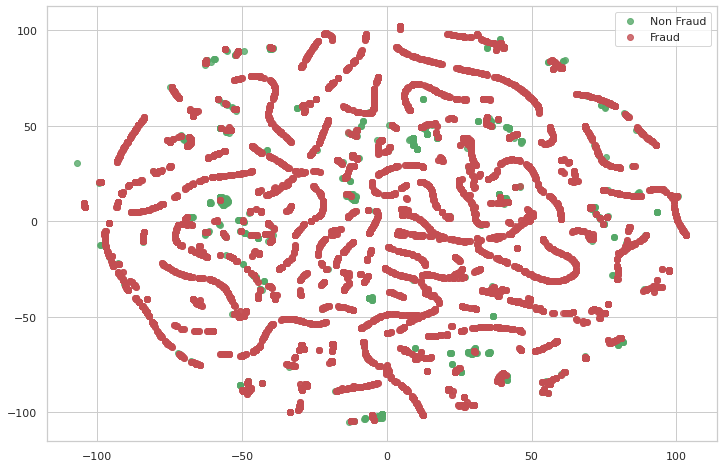

In [59]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [60]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [61]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [ ]:
x = data.drop(["LABEL"], axis=1)
y = data["LABEL"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [ ]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

In [ ]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [ ]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [ ]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")